# BBC news classification project

The goal of this project is to classify BBC news articles into five categories: business, entertainment, politics, sports and tech. To do this I did a small EDA, cleaned the text and extracted word features with tf-idf. For the unsupervised approach, I used nmf to get topics and then assign labels by the closest class centroid.  For the supervised baseline, I used tf-idf and linear svc because its a good text classifier. I reported validation accuracy using a 80/20 split

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-bbc/BBC News Train.csv
/kaggle/input/ai-bbc/BBC News Sample Solution.csv
/kaggle/input/ai-bbc/BBC News Test.csv


In [6]:
import pandas as pd

bbctrain = "/kaggle/input/ai-bbc/BBC News Train.csv"
bbctest = "/kaggle/input/ai-bbc/BBC News Test.csv"

traindat = pd.read_csv(bbctrain)
testdat = pd.read_csv(bbctest)

traindat = traindat.rename(columns={"Text": "Article"})
testdat = testdat.rename(columns={"Text": "Article"})

print("Shapes:", traindat.shape, testdat.shape)
print(traindat.head(2)[["ArticleId","Article","Category"]])
print(testdat.head(2)[["ArticleId","Article"]])

Shapes: (1490, 3) (735, 2)
   ArticleId                                            Article  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
   ArticleId                                            Article
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...


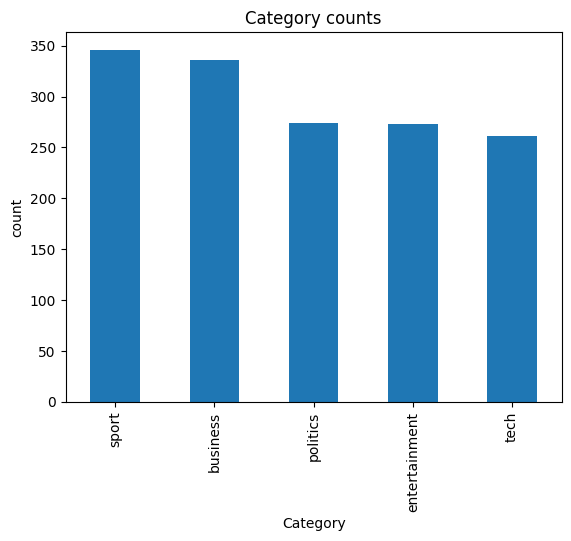

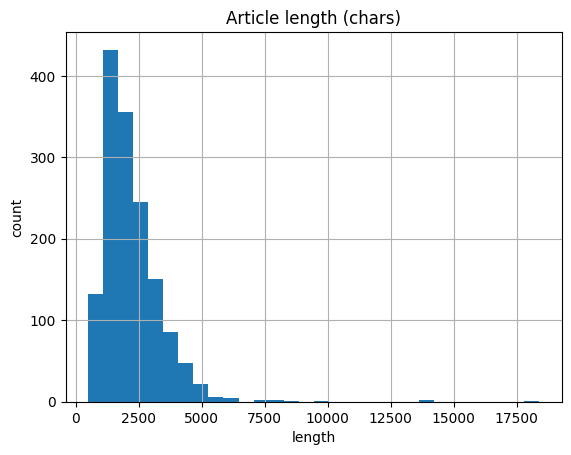

                                             Article  \
0  worldcom ex-boss launches defence lawyers defe...   
1  german business confidence slides german busin...   
2  bbc poll indicates economic gloom citizens in ...   

                                               clean  Category  
0  worldcom ex boss launches defence lawyers defe...  business  
1  german business confidence slides german busin...  business  
2  bbc poll indicates economic gloom citizens in ...  business  


In [7]:
import matplotlib.pyplot as plt
import re

# class counts
traindat["Category"].value_counts().plot(kind="bar", title="Category counts")
plt.ylabel("count")
plt.show()

# article length histgram
traindat["len"] = traindat["Article"].astype(str).str.len()
traindat["len"].hist(bins=30)
plt.title("Article length (chars)")
plt.xlabel("length")
plt.ylabel("count")
plt.show()

# lowercase, drop urls/punct and remove space
def mrclean(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", "", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# train and test
traindat["clean"] = traindat["Article"].apply(mrclean)
testdat["clean"] = testdat["Article"].apply(mrclean)

print(traindat[["Article","clean","Category"]].head(3))

## EDA summary

I plotted the class counts and a histogram of article lengths. For cleaning, I lowercased the text, removed urls and punctuation and removed extra spaces. I kept words and numbers. I used tf-idf for both models. I used an unsupervised model with nmf and a supervised model with tf-idf and linear svc

## Unsupervised

I used tf-idf to turn news text into numbers that show how important the word is for that text. This gave me a long vector of numbers per text. I then used nmf to find 5 topics since the dataset had 5 classes. Each news text got a short vector of 5 numbers that shows how strongly it matched topic. To get labels from topics, I averaged the 5 number vectors for each class. I then labeled each new news text with the class whose average vector was the most similar

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# 80/20 split by position
cut = int(len(traindat) * 0.8)

# vectorizer + nmf
tfvect = TfidfVectorizer(min_df=2, ngram_range=(1,2))
numtop = 5
nmfmod = NMF(n_components=numtop, init="nndsvd", random_state=0, max_iter=200)

# nmf on train slice 
trainmat = nmfmod.fit_transform(tfvect.fit_transform(traindat.loc[:cut-1, "clean"]))
# nmf on val slice 
valmat = nmfmod.transform(tfvect.transform(traindat.loc[cut:, "clean"]))

# labels and class centroids
labels = sorted(traindat.loc[:cut-1, "Category"].unique())
classc = {}
for c in labels:
    classc[c] = normalize(trainmat[np.array(traindat.loc[:cut-1, "Category"] == c)], norm="l2").mean(axis=0)

# closest centroid predictor
def nearc(H, classc, labels):
    return np.array([labels[i] for i in np.asarray((normalize(H, norm="l2") @ np.vstack([classc[c] for c in labels]).T).argmax(axis=1)).ravel()])

# validation acc
valacc = accuracy_score(traindat.loc[cut:, "Category"], nearc(valmat, classc, labels))
print("Unsupervised NMF val accuracy:", round(valacc, 4))

# full train fit 
tfall = TfidfVectorizer(min_df=2, ngram_range=(1,2))
trainmat = nmfmod.fit_transform(tfall.fit_transform(traindat["clean"]))  

# recompute centroids on full train
classc = {}
for c in labels: classc[c] = normalize(trainmat[np.array(traindat["Category"] == c)], norm="l2").mean(axis=0)

# test topics 
valmat = nmfmod.transform(tfall.transform(testdat["clean"]))

# predict
testpred = nearc(valmat, classc, labels)
subdat = pd.DataFrame({"ArticleId": testdat["ArticleId"], "Category": testpred})
subdat.to_csv("submission_unsupervised_nmf.csv", index=False)
print(subdat.head())
print("file: submission_unsupervised_nmf.csv")

Unsupervised NMF val accuracy: 0.906
   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport
file: submission_unsupervised_nmf.csv


## Unsupervised results

The validation accuracy was .906. I didnt include the test texts when I fit tf-idf or nmf. I fit on the training part, transformed the validation and test with those fitted objects and then predicted

## Supervised 

I used tf-idf with unigrams and bigrams and trained a linear svc classifier. I kept the same 80/20 split for validation

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import pandas as pd

# 80/20 
cut = int(len(traindat) * 0.8)

# vectorizer
tfsup = TfidfVectorizer(min_df=2, ngram_range=(1,2))
tftrainmat = tfsup.fit_transform(traindat.loc[:cut-1, "clean"])
tfvalmat = tfsup.transform(traindat.loc[cut:, "clean"])

# train lin svc
linsvc = LinearSVC()
linsvc.fit(tftrainmat, traindat.loc[:cut-1, "Category"])

# validation acc
valpreds = linsvc.predict(tfvalmat)
valaccsup = accuracy_score(traindat.loc[cut:, "Category"], valpreds)
print("Supervised TF-IDF + LinearSVC val accuracy:", round(valaccsup, 4))

# train on full 
tfmodall = TfidfVectorizer(min_df=2, ngram_range=(1,2))
clfmodall = LinearSVC()
clfmodall.fit(tfmodall.fit_transform(traindat["clean"]), traindat["Category"])

testpredsup = clfmodall.predict(tfmodall.transform(testdat["clean"]))
subdatsup = pd.DataFrame({"ArticleId": testdat["ArticleId"], "Category": testpredsup})
subdatsup.to_csv("submission_supervised.csv", index=False)
print(subdatsup.head())
print("file: submission_supervised.csv")

Supervised TF-IDF + LinearSVC val accuracy: 0.9732
   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport
file: submission_supervised.csv


## Results and comparison

The unsupervised method reached a validation accuracy of 0.906. The supervised method reached a validation accuracy of 0.9732. 
The supervised model did better because it learned directly from the labels. The nmf approach grouped texts by word patterns without labels so it was less accurate 

## Conclusion

A simple pipeline worked really well. Tf-idf features captured useful signals and linear svc was accurate. Nmf with closest centroid gave me a reasonable unsupervised baseline. The results showed the benefit of labels. If I continued to work on this, I would try different topic counts and make changes to linear svc